In [56]:
# run instead of import to be able to serialize the functions and send them to the workers
# otherwise one would need to upload the file explicitely for each worker
%run utils.py

In [4]:
import dask
import dask.distributed

In [5]:
#dask.config.set({'distributed.worker.memory.target': 0.4})
#dask.config.set({'distributed.worker.memory.pause': 0.5})

In [6]:
dask.config.config["distributed"]["worker"]["memory"]

{'target': 0.6, 'spill': 0.7, 'pause': 0.8, 'terminate': 0.95}

In [7]:
from ipywidgets import FileUpload
upload = FileUpload()
display(upload)

FileUpload(value={}, description='Upload')

In [9]:
setup_rucio_and_proxy(upload.data[-1], rucio_account="nihartma")

In [10]:
import physlite_experiments
from physlite_experiments.physlite_events import physlite_events
from physlite_experiments.analysis_example import get_obj_sel
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import rucio.client
from tqdm.auto import tqdm
import requests
import io

first, list the filenames:

In [11]:
rucio_client = rucio.client.Client()

In [12]:
files = list(rucio_client.list_files("data17_13TeV", "data17_13TeV.periodK.physics_Main.PhysCont.DAOD_PHYSLITE.grp17_v01_p4309"))

In [14]:
files[0]

{'scope': 'data17_13TeV',
 'name': 'DAOD_PHYSLITE.22958312._000001.pool.root.1',
 'bytes': 339098731,
 'adler32': 'ea4a58e1',
 'guid': '9182E93759873A4BA6ABC72E1C286873',
 'events': 42870}

In [16]:
url = get_signed_url(rucio_client, files[0]["scope"], files[0]["name"])

The analysis will be run on data directly downloaded into memory:

In [17]:
def download(url):
    return requests.get(url).content

In [18]:
data = download(url)

In [19]:
rootfile = uproot.open(io.BytesIO(data))

In [20]:
tree = rootfile["CollectionTree"]

In [21]:
from physlite_experiments.utils import subdivide
import math

In [22]:
events = physlite_events(tree)

Skipping EventInfoAuxDyn.streamTagRobs
Skipping EventInfoAuxDyn.streamTagDets
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Skipping AnalysisHLT_mu14_ivarloose_tau25_medium1_tracktwo_L1DR-MU10TAU12I_TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_e17_lhmedium_nod0_ivarloose_tau25_medium1_tracktwo_L1DR-EM15TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_03dR30_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_tautsf_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau80_medium1_tracktwo_L1TAU60_tau35_medium1_tracktwo_L1TAU12IM_L1TAU60_DR-TAU20ITAU12IAuxDyn.TrigMatchedObjects


In [23]:
events.Electrons.pt

<Array [[], [], [], [], ... [], [4.81e+03], []] type='42870 * var * float32'>

This is the actual analysis part, it runs some object selections on Electrons, Muons, Jets with overlap removal and adds `baseline`, `signal` and `passOR` fields.

In [24]:
events_decorated = get_obj_sel(events)

/srv/conda/envs/notebook/lib/python3.8/site-packages/awkward/_connect/_numpy.py:160: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(


In this version i forgot to add the muon mass, so let's add it to do some dilepton invariant mass plots:

In [25]:
events_decorated["Muons", "m"] = 105.6583715

In [26]:
leptons = ak.concatenate([events_decorated.Electrons, events_decorated.Muons], axis=1)
leptons = ak.with_parameter(leptons, "__record__", "xAODParticle")

In [27]:
l1, l2 = ak.unzip(ak.combinations(leptons.mask[leptons.signal & leptons.passOR], 2))

In [28]:
m = (l1 + l2).mass
m = ak.flatten(m, axis=None)
m = ak.to_numpy(m)

Dilepton invariant mass for signal leptons - the Upsilon and the Z peak are visible already from one file:

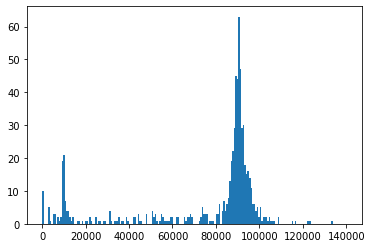

In [29]:
plt.hist(m, bins=200, range=(0, 140000));

let's wrap it into a single function that takes the binary data and outputs an arrow buffer for the lepton 4-momenta and the object selection flags:

In [30]:
import gc

In [31]:
def get_leptons(data, max_chunksize=50000):
    with uproot.open(io.BytesIO(data)) as f:
        tree = f["CollectionTree"]
        entry_start = 0
        leptons = []
        n = tree.num_entries
        for chunksize in subdivide(n, math.ceil(n / max_chunksize)):
            entry_stop = entry_start + chunksize
            events = physlite_events(tree, entry_start=entry_start, entry_stop=entry_stop)
            entry_start = entry_stop
            events_decorated = get_obj_sel(events)
            events_decorated["Muons", "m"] = 105.6583715
            leptons.append(
                ak.concatenate([events_decorated.Electrons, events_decorated.Muons], axis=1)
            )
        leptons = ak.concatenate(leptons)
        leptons = ak.to_arrow(leptons[["pt", "eta", "phi", "m", "passOR", "baseline", "signal"]])
    gc.collect()
    return leptons

In [32]:
%%time
l = ak.from_arrow(get_leptons(data, max_chunksize=20000))

Skipping EventInfoAuxDyn.streamTagRobs
Skipping EventInfoAuxDyn.streamTagDets
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Skipping AnalysisHLT_mu14_ivarloose_tau25_medium1_tracktwo_L1DR-MU10TAU12I_TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_e17_lhmedium_nod0_ivarloose_tau25_medium1_tracktwo_L1DR-EM15TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_03dR30_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_tautsf_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau80_medium1_tracktwo_L1TAU60_tau35_medium1_tracktwo_L1TAU12IM_L1TAU60_DR-TAU20ITAU12IAuxDyn.TrigMatchedObjects
Skipping EventInfoAuxDyn.streamTagRobs
Skipping EventInfoAuxDyn.streamTagDets
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Skipping

In [33]:
len(l)

42870

And then run it on dask on all files:

In [34]:
from dask import delayed
import dask

In [35]:
# local cluster:
#from dask.distributed import Client

#client = Client(n_workers=8, threads_per_worker=1)
#client

In [36]:
#client.shutdown()

In [37]:
# enter proxy/8787 in field on the left

In [38]:
#client.restart()

In [42]:
# gateway cluster
from dask_gateway import GatewayCluster
cluster = GatewayCluster(
    worker_cores=2,
    worker_memory=8,
    image="eu.gcr.io/gke-dev-311213/dask-gateway-physlite:20210616"
)

In [43]:
cluster

In [168]:
#cluster.scale(100)
cluster.scale(50)
#cluster.scale(1)

In [188]:
#cluster.shutdown()

In [49]:
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.8/site-packages/distributed/client.py:1129: VersionMismatchWarning: Mismatched versions found

+---------+---------------+---------------+---------------+
| Package | client        | scheduler     | workers       |
+---------+---------------+---------------+---------------+
| numpy   | 1.19.4        | 1.19.2        | 1.19.2        |
| python  | 3.8.6.final.0 | 3.8.3.final.0 | 3.8.3.final.0 |
+---------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [167]:
client.restart()

Client Scheduler: gateway://traefik-dhub-dask-gateway.default:80/default.18d07f2e4e854b2eb7da248321d4b718 Dashboard: /services/dask-gateway/clusters/default.18d07f2e4e854b2eb7da248321d4b718/status,Cluster Workers: 1 Cores: 2 Memory: 8.59 GB


build the task graph:

In [122]:
from functools import partial

In [124]:
fut = client.submit(partial(get_signed_url_worker, rucio_account="nihartma"), upload.data[-1], files[0]["scope"], files[0]["name"])

In [126]:
#fut.result()

In [169]:
delayed_leptons = []
#for file in files[::10][:20]:
for file in files[::10]:
    if file["bytes"] > 500000000:
        continue
    d_url = delayed(partial(get_signed_url_worker, rucio_account="nihartma"))(
        upload.data[-1],
        file["scope"],
        file["name"],
    )
    d_data = delayed(download)(d_url)
    delayed_leptons.append(delayed(get_leptons)(d_data))

In [171]:
from dask.distributed import performance_report, wait, fire_and_forget

to save task graph:
```python
with performance_report(filename="dask-report-1percent.html"):
    (delayed_leptons,) = dask.persist(delayed_leptons)
    wait(delayed_leptons)
    #fire_and_forget(dask.compute(delayed_leptons))
```

In [173]:
with performance_report(filename="dask-report-1percent-with-list-replicas.html"):
    (delayed_leptons,) = dask.persist(delayed_leptons)
    wait(delayed_leptons)

In [174]:
#(delayed_leptons,) = dask.persist(delayed_leptons)

In [175]:
def get_mass(leptons, selection="all"):
    leptons = ak.from_arrow(leptons)
    leptons = ak.with_parameter(leptons, "__record__", "xAODParticle")
    if selection == "all":
        l1, l2 = ak.unzip(ak.combinations(leptons, 2))
    elif selection == "signal":
        l1, l2 = ak.unzip(ak.combinations(leptons.mask[leptons.signal & leptons.passOR], 2))
    elif selection == "baseline":
        l1, l2 = ak.unzip(ak.combinations(leptons.mask[leptons.baseline & leptons.passOR], 2))
    l1, l2 = [ak.with_parameter(i, "__record__", "xAODParticle") for i in [l1, l2]]
    m = (l1 + l2).mass
    m = ak.flatten(m, axis=None)
    m = ak.to_numpy(m)
    return m

In [176]:
l = dask.compute(delayed_leptons[0])

In [178]:
from dask.distributed import futures_of

In [179]:
delayed_leptons_ok = [t for t in delayed_leptons if futures_of(t)[0].status == "finished"]

In [180]:
len(delayed_leptons_ok)

1668

In [181]:
len(delayed_leptons)

1676

In [182]:
from functools import partial

In [183]:
(m_list_all,) = dask.compute([delayed(partial(get_mass, selection="all"))(i) for i in delayed_leptons_ok])

In [184]:
(m_list_baseline,) = dask.compute([delayed(partial(get_mass, selection="baseline"))(i) for i in delayed_leptons_ok])

In [185]:
GeV = 1000

<ipython-input-186-0c87b43aa386>:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1e7)


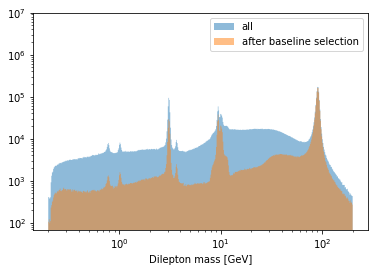

In [186]:
opts = dict(
    bins=np.geomspace(0.2, 200, 500),
    histtype="stepfilled", alpha=0.5
)
plt.hist(np.concatenate(m_list_all) / GeV, label="all", **opts);
plt.hist(np.concatenate(m_list_baseline) / GeV, label="after baseline selection", **opts);
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Dilepton mass [GeV]")
plt.legend()
plt.ylim(0, 1e7)
plt.savefig("m2l_baseline_1percent.pdf")